<a href="https://colab.research.google.com/github/rodmart21/Sport_stats/blob/main/Nba_Shot_Representation_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Data visualization

### Import all necessary libraries

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.neural_network import MLPClassifier


From this url we can extract the data available: https://www.kaggle.com/datasets/wh0801/NBA-16-17-regular-season-shot-log

In [2]:
shot = pd.read_csv("/content/shot log ATL.csv")   # The root in my case.
pd.set_option('display.max_columns', 100)
print(shot.columns.tolist())
shot.describe()

['self previous shot', 'player position', 'home game', 'location x', 'opponent previous shot', 'home team', 'shot type', 'points', 'away team', 'location y', 'time', 'date', 'shoot player', 'time from last shot', 'quarter', 'current shot outcome']


,location x,points,location y,time from last shot,quarter
count,6912.000000,6917.000000,6912.000000,6581.000000,6917.000000
mean,469.309462,2.308804,254.853733,33.827838,2.511638
std,346.539985,0.462034,106.991007,20.726647,1.166225
min,15.000000,2.000000,0.000000,0.000000,1.000000
25%,83.500000,2.000000,216.000000,23.000000,1.000000
50%,566.500000,2.000000,250.000000,31.000000,2.000000
75%,851.000000,3.000000,300.000000,41.000000,3.000000
max,920.000000,3.000000,500.000000,216.000000,8.000000


With scatter every shot is represented as a point. It is clear how most of the shots come from the paint zone.

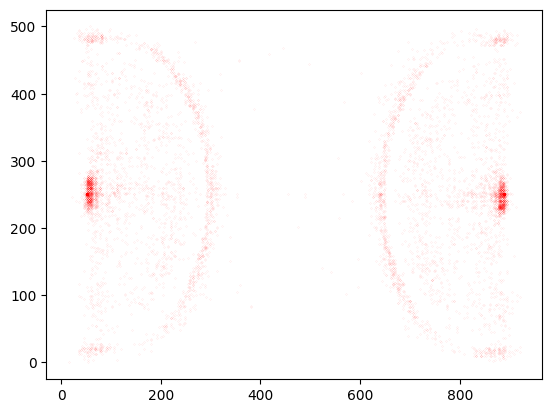

In [3]:
x = shot['location x']
y = shot['location y']
plt.scatter(x,y, s=.005,c='r', marker= '.')

Making the plot bigger it is easier to watch every point in its position.

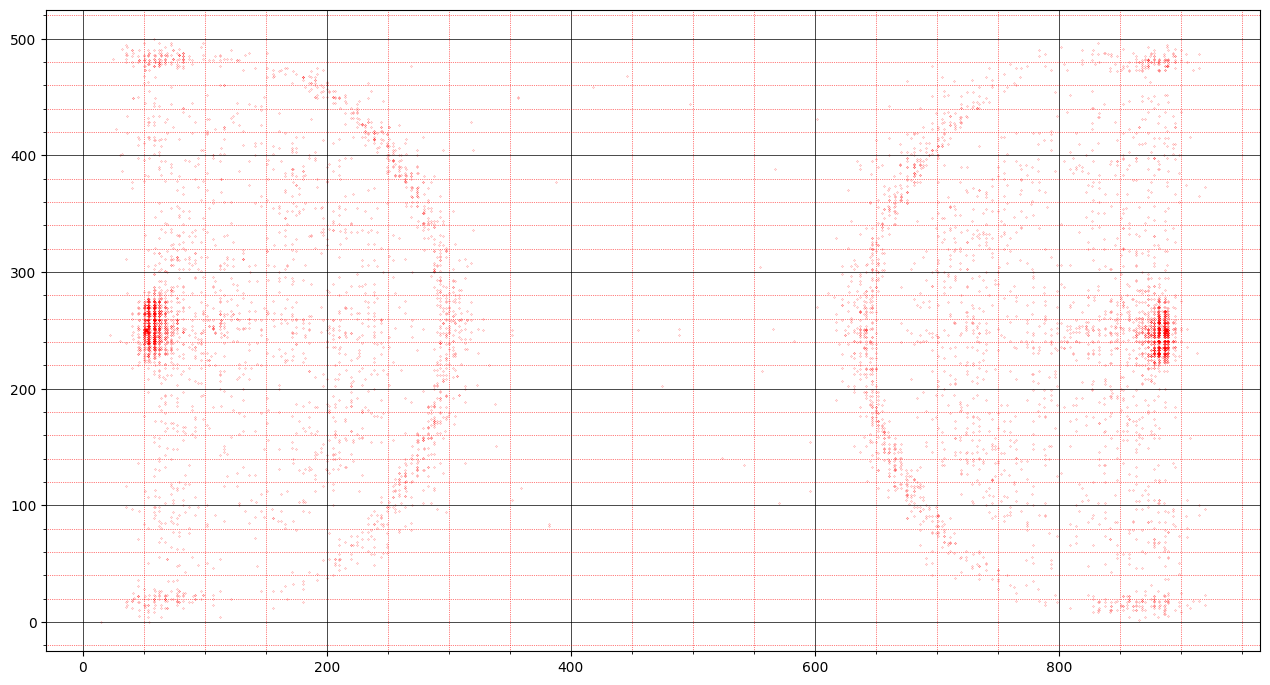

In [4]:
plt.figure(figsize=(94/6,50/6))
plt.scatter(x,y, s=.1,c='r', marker= '.')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='red')

With the correct adjustments, ti is posible to plot everything in just one half court.

In [5]:
shot['halfcourt_x'] =np.where(shot['location x'] < 933/2, 933 - shot['location x'],shot['location x'])
shot['halfcourt_y'] =np.where(shot['location x'] < 933/2, 500 - shot['location y'],shot['location y'])
shot.describe()

,location x,points,location y,time from last shot,quarter,halfcourt_x,halfcourt_y
count,6912.000000,6917.000000,6912.000000,6581.000000,6917.000000,6912.000000,6912.000000
mean,469.309462,2.308804,254.853733,33.827838,2.511638,800.794560,242.963397
std,346.539985,0.462034,106.991007,20.726647,1.166225,91.262435,106.869625
min,15.000000,2.000000,0.000000,0.000000,1.000000,475.000000,0.000000
25%,83.500000,2.000000,216.000000,23.000000,1.000000,718.000000,195.000000
50%,566.500000,2.000000,250.000000,31.000000,2.000000,851.000000,248.000000
75%,851.000000,3.000000,300.000000,41.000000,3.000000,879.000000,280.000000
max,920.000000,3.000000,500.000000,216.000000,8.000000,920.000000,500.000000


Every parameter defined here can be changed so the graphic representation is different.

Text(0.5, 1.0, 'Shots')

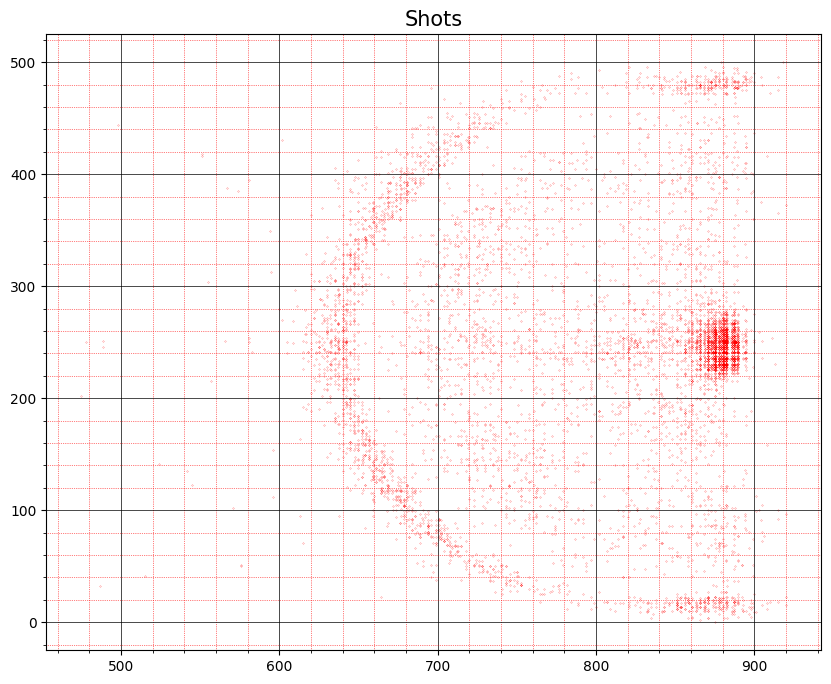

In [6]:
hx = shot['halfcourt_x']
hy = shot['halfcourt_y']
plt.figure(figsize=(10,8))
plt.scatter(hx,hy, s=.1,c='r', marker= '.')
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='red')
plt.title("Shots", fontsize = 15)


In [7]:
shot.head(3)

,self previous shot,player position,home game,location x,opponent previous shot,home team,shot type,points,away team,location y,time,date,shoot player,time from last shot,quarter,current shot outcome,halfcourt_x,halfcourt_y
0,NaN,SF,Yes,97.0,SCORED,ATL,Pullup Jump Shot,2,WAS,405.0,1:09,2016-10-27,Kent Bazemore,NaN,1,MISSED,836.0,95.0
1,MISSED,C,Yes,52.0,SCORED,ATL,Tip Dunk Shot,2,WAS,250.0,1:11,2016-10-27,Dwight Howard,2.0,1,SCORED,881.0,250.0
2,SCORED,SG,Yes,239.0,MISSED,ATL,Jump Shot,2,WAS,223.0,1:41,2016-10-27,Kyle Korver,30.0,1,SCORED,694.0,277.0


In [8]:
shot.columns

Index(['self previous shot', 'player position', 'home game', 'location x',
       'opponent previous shot', 'home team', 'shot type', 'points',
       'away team', 'location y', 'time', 'date', 'shoot player',
       'time from last shot', 'quarter', 'current shot outcome', 'halfcourt_x',
       'halfcourt_y'],
      dtype='object')

Using a pivot table we are able to list players by their shots and check their performance.

In [9]:
playersn = shot.groupby('shoot player')['current shot outcome'].describe().reset_index()
playersn.sort_values(by = 'count', ascending = False)

,shoot player,count,unique,top,freq
1,Dennis Schroder,1215,3,MISSED,555
14,Paul Millsap,972,3,MISSED,487
18,Tim Hardaway Jr.,912,3,MISSED,448
6,Kent Bazemore,722,3,MISSED,397
2,Dwight Howard,614,3,SCORED,388
17,Thabo Sefolosha,394,3,MISSED,195
10,Malcolm Delaney,387,3,MISSED,223
12,Mike Muscala,337,3,SCORED,170
16,Taurean Prince,286,3,MISSED,144
8,Kyle Korver,245,3,MISSED,134


Unique represents the number of posible outcomes a shot has. Top is the most possible output from a specific shot and frecuency represents the number of times a shot has had that output.

Chosing one specific player we can see the kind of shots he is taking and compare it with some other teammate

In [10]:
Tim = shot[shot['shoot player'] == 'Tim Hardaway Jr.']
len_cal = Tim.shape[0]
Dennis = shot[shot['shoot player'] == 'Dennis Schroder'][0:(len_cal)]

Text(0.5, 1.0, 'Schroder-Hardaway comparison')

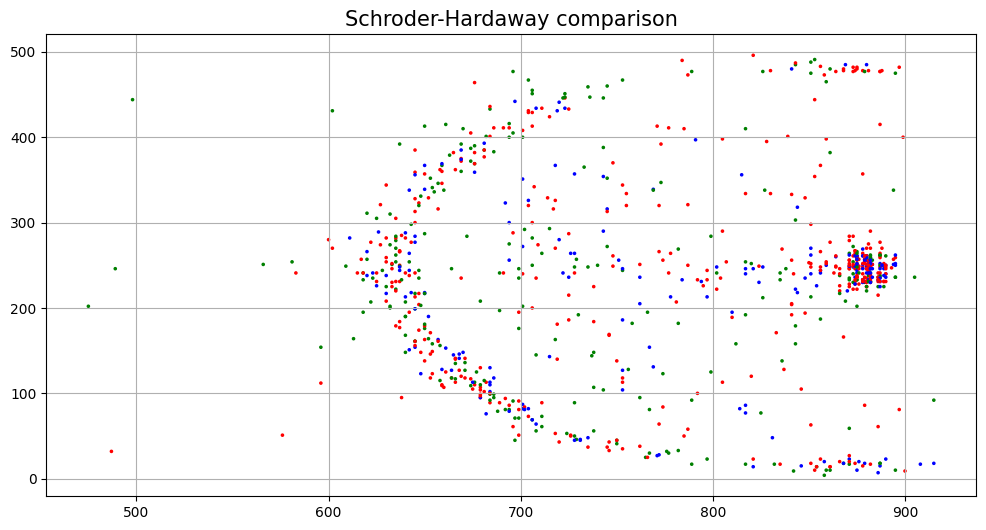

In [11]:
hxL = Tim['halfcourt_x']
hyL = Tim['halfcourt_y']
colors = np.where(Dennis['current shot outcome']=='SCORED','r',np.where(Tim['current shot outcome']=='SCORED','b','g'))
plt.figure(figsize=(12,6))
plt.scatter(hxL,hyL, s=10, c= colors, marker= '.')
plt.grid(True)
plt.title("Schroder-Hardaway comparison", fontsize = 15)

The shots scored by Dennis are represented in red, and the shots scored by Tim are represented in blue. The green points represent the cases where neither of the two players scores.

With this type of visualization, it's easy to identify the shots along the three-point line, but the shots from inside the paint appear very uniform. With this new plot, we zoom into this type of shots.



In [12]:
rect1 = shot[(((shot['location x']>700) & (shot['location x']<900)) & \
                 ((shot['location y'] > 200) & (shot['location y'] < 300)))]

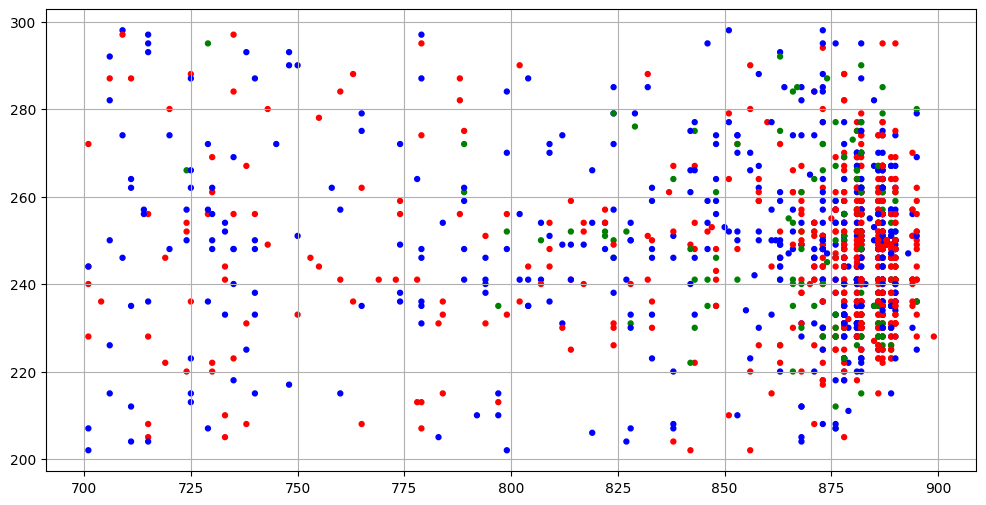

In [13]:
xr = rect1['location x']
yr = rect1['location y']
colors = np.where(rect1['current shot outcome']=='SCORED','r',np.where(rect1['current shot outcome']=='MISSED','b','g'))
plt.figure(figsize=(12,6))
plt.scatter(xr,yr, s=50, c= colors, marker= '.')
plt.grid(True)

## 2) Model development

## 2.1) Analysis of the available data

Consider all the variables deemed necessary in this case that can define whether a shot will be scored or missed. The position on the field and the type of shot appear to be the most decisive variables when a shot is taken.

In [14]:
shot_model=shot[['halfcourt_x','halfcourt_y','shot type','current shot outcome']]

We are only interested in the shot going in or not, so we redefine all the block shots as failed shots. We also select only the 4 most repeated shot types.

In [15]:
shot_model['current shot outcome'].value_counts()

current shot outcome
MISSED     3369
SCORED     3123
BLOCKED     425
Name: count, dtype: int64

In [16]:
shot_model.loc[shot_model['current shot outcome'] == 'BLOCKED', 'current shot outcome'] = 'MISSED'

In [17]:
shot_model['current shot outcome'].value_counts()

current shot outcome
MISSED    3794
SCORED    3123
Name: count, dtype: int64

In [18]:
shot_model = shot_model[shot_model['shot type'].isin(['Jump Shot', 'Pullup Jump Shot', 'Driving Layup', 'Layup'])]

After this transformations the number of rows available to use in our models is a little bit reduced, but this is a logic consecuenque of the typical pre-analysis of data requiered in every data science project.

In [19]:
shot_model.shape

(3994, 4)

Finally, the data must be converted to dummy variables where we define each possible aspect with a number. We could have converted each value into a specific number but these could some problems if the model asumes that there is some kind of ordinal relationship between them.


One-hot encoding can increase the memory consumed by the model, but it is the best way to avoid potential misunderstandings.

The results are binary so there is no problem there defining each possible outcome as 0 or 1.

In [20]:
shot_model = pd.get_dummies(shot_model, columns=['shot type'])
shot_model['current shot outcome'] = shot_model['current shot outcome'].map({'MISSED': 0, 'SCORED': 1})

In [21]:
shot_model.head(2)

,halfcourt_x,halfcourt_y,current shot outcome,shot type_Driving Layup,shot type_Jump Shot,shot type_Layup,shot type_Pullup Jump Shot
0,836.0,95.0,0,False,False,False,True
2,694.0,277.0,1,False,True,False,False


Elimination of all the rows with NaN values.

In [22]:
shot_model=shot_model.dropna()

## 2.2) Training of the model

Split our data in training and test datasets, with having the 20% in the test group is enough.

In [47]:
X = shot_model.drop(columns=['current shot outcome'])
#X = shot_model[['halfcourt_x','halfcourt_y','shot type_Driving Layup']]
y = shot_model['current shot outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Building a pipeline like this simplifies the modeling process, improves code readability, and ensures consistency in data preprocessing and modeling. It is important to decide the model we will use, Logistic Regression is a simple model, but it usually gives really good results.

Grid Search automatically explores a predefined set of hyperparameters and finds the combination that maximizes performance metrics, such as accuracy, precision, or recall.

In [48]:
pipeline = Pipeline([('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))])

param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


## 2.3) Testing of the results obtained.

Our model makes the predictions for the unseen data.

In [49]:
y_pred = best_model.predict(X_test)

There are many ways of checking out the results of the model, these are some of them.

The classification report gives a precise photo of the performance of the model.
-The precision calculates the correct positive predictions over the total positive predictions. TP/(TP+FP)
-The recall measures the correct positive predictions over the total positive real cases. TP/(TP+FN)
-The f1-score is just the armonic medium between this two metrics

In [51]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       254
           1       0.45      0.54      0.49       145

    accuracy                           0.59       399
   macro avg       0.58      0.58      0.58       399
weighted avg       0.61      0.59      0.60       399



The confusion matrix is a common representation of classification results that allows you to easily see how many instances have been correctly labeled.

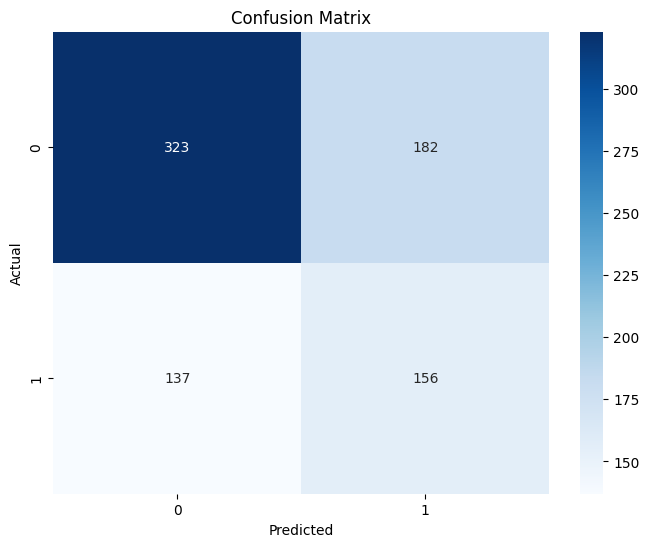


Best Hyperparameters: {'classifier__C': 0.001, 'classifier__solver': 'newton-cg'}


In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 2.4) Using other models.

The results with the previously developed Logistic Regression model were not very impressive. It only managed to correctly identify the categories just over half of the time.

Let's try using different models and changing some hyperparameters and the check out the performance of the model.

Previously, with Logistic Regression, we used class_weight='balanced' to ensure that the model would account for the minority class and give it the same importance as the majority class. Now we use SMOTE, it creates artificial data in the minority class so both of them are balanced.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_res, y_train_res)
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Accuracy: 0.581453634085213

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       505
           1       0.43      0.41      0.42       293

    accuracy                           0.58       798
   macro avg       0.55      0.55      0.55       798
weighted avg       0.58      0.58      0.58       798



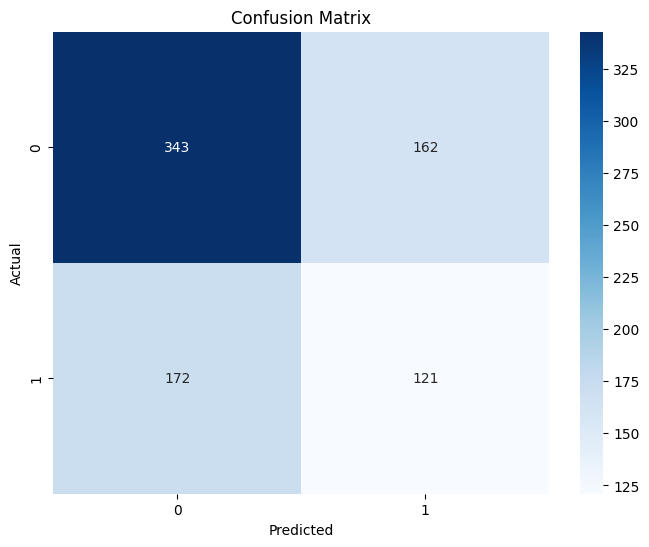


Best Hyperparameters: {'classifier__max_depth': 30, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}


In [52]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nBest Hyperparameters:", grid_search.best_params_)

Performance doesn't improve, so the better solution might be making the training datset bigger.

Nevertheless, a Neural Network can improve the results, even though it will also be more consuming in terms of memory. Inside the param_grid there are defined different parameters of the Neural Network so we can test which are the ones that fit better with this specific task.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(max_iter=1000, random_state=42))
])

param_grid = {
    'classifier__hidden_layer_sizes': [(50, 50), (100,)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train_res, y_train_res)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Accuracy: 0.6077694235588973

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       505
           1       0.47      0.58      0.52       293

    accuracy                           0.61       798
   macro avg       0.60      0.60      0.59       798
weighted avg       0.63      0.61      0.61       798



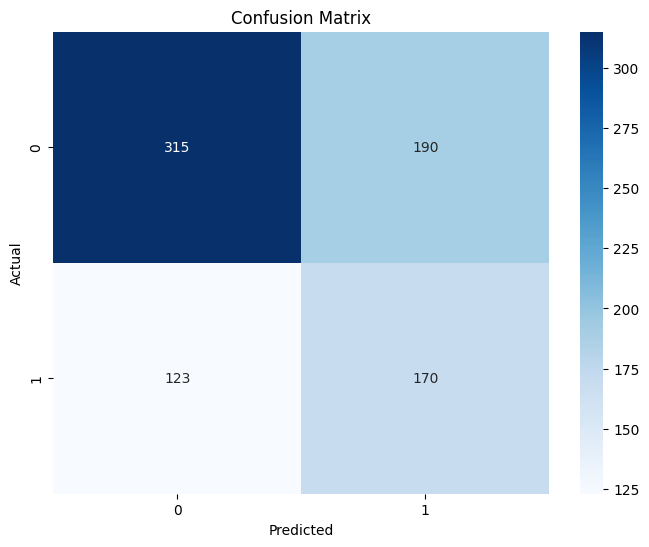


Best Hyperparameters: {'classifier__activation': 'relu', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50, 50), 'classifier__learning_rate': 'constant', 'classifier__solver': 'adam'}


In [53]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nBest Hyperparameters:", grid_search.best_params_)

The results show a slight improvement compared to the utilization of conventional ML models. However, this enhancement is not deemed significant enough when considering the substantial increase in memory consumption.